In [1]:
#Black-Scholes-Merton python计算公式
import numpy as np
from math import sqrt, log
from scipy import stats
#
# 欧式期权BSM定价公式
def bsm_call_value(S0, K, T, r, sigma):
    """
    Parameters:
    ==========
    S0: float
        标的物初始价格水平
    K: float
       行权价格
    T: float
       到期日
    r: float
       固定无风险短期利率
    sigma: float
       波动因子
    Returns
    ==========
    value: float
    """
    S0 = float(S0)
    d1 = (np.log(S0 /K) + (r + 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
    d2 = (np.log(S0 /K) + (r - 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0, 1))
    return value
    
def bsm_vega(S0, K, T, r, sigma):
    """
    Vega 计算
    """
    S0 = float(S0)
    d1 = (np.log(S0/K)) + (r+0.5*sigma**2)*T /(sigma*sqrt(T))
    vega = S0 * stats.norm.cdf(d1, 0, 1) * np.sqrt(T)
    return vega

def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0)
                     / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

S0 = 1
K = 2
T = 2
r = 0.01
sigma = 0.1
C0 = 1
bsm_call_imp_vol(S0, K, T, r, C0, sigma, it=2000)
import pandas as pd
h5 = pd.HDFStore('./vstoxx_data_31032014.h5','r')
futures_data = h5['futures_data']
options_data = h5['options_data']
futures_data['DATE'] = pd.to_datetime(futures_data['DATE'])
options_data['DATE'] = pd.to_datetime(options_data['DATE'])
futures_data['MATURITY'] = pd.to_datetime(futures_data['MATURITY'])
options_data['MATURITY'] = pd.to_datetime(options_data['MATURITY'])
h5.close()


D:\ANACD\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-2-8d7be75e6995>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = plot_data[options_data.MATURITY==maturity]
<ipython-input-2-8d7be75e6995>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = plot_data[options_data.MATURITY==maturity]
<ipython-input-2-8d7be75e6995>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = plot_data[options_data.MATURITY==maturity]
<ipython-input-2-8d7be75e6995>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = plot_data[options_data.MATURITY==maturity]
<ipython-input-2

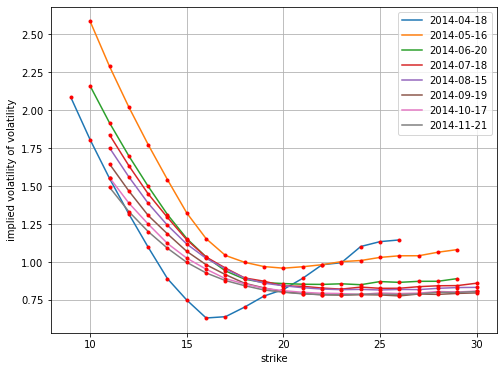

In [2]:
V0 = 17.6639
r = 0.01
# imp_vol  -> implied volality
options_data['IMP_VOL'] = 0.0
tol = 0.5 #tolerance
for option in options_data.index:
    item = options_data.loc[option]
    forward = futures_data[futures_data['MATURITY']== \
                           item['MATURITY']]['PRICE'].values[0]
    if (forward * (1 - tol) < item['STRIKE'] 
        < forward*(1 + tol)):
        imp_vol = bsm_call_imp_vol(V0,
                                  item['STRIKE'],
                                  item['TTM'],
                                  r,
                                  item['PRICE'],
                                  sigma_est=2.,
                                  it=100)
        options_data['IMP_VOL'].loc[option] = imp_vol
plot_data = options_data[options_data['IMP_VOL']>0]
maturies = sorted(set(options_data['MATURITY']))
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for maturity in maturies:
    data = plot_data[options_data.MATURITY==maturity]
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=maturity.date(), lw=1.5
            )
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()
